In [1]:
## Install the required dependencies
! python -m pip install mpi4py
! mkdir serial_output
! mkdir parallel_output
! mkdir norms
! mkdir parallel_steps
! mkdir sub_domains
! mkdir test_output
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 7.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185290 sha256=356a2f41441f6e57d28bbcc3197a1efc2a3398429fdc7b2b4a452134daa1a2be
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


## Tool functions

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# view 3D result from xy, yz, xz planes
def plot_cube(result_cube, view_loc):
  fig, ax = plt.subplots(1,3, figsize=[20,5])
  plt.subplot(1,3,1)
  plt.imshow(result_cube[0,:,:,view_loc,0], cmap='jet')
  plt.colorbar()
  plt.title('central yz plane',Fontsize=20)
  plt.subplot(1,3,2)
  plt.imshow(result_cube[0,:,view_loc,:,0], cmap='jet')
  plt.colorbar()
  plt.title('central xz plane',Fontsize=20)
  plt.subplot(1,3,3)
  plt.imshow(result_cube[0,view_loc,:,:,0], cmap='jet')
  plt.colorbar()
  plt.title('central xy plane',Fontsize=20)

def plot_cube_3D(result_cube):
  # Create axis
  x,y,z = result_cube.shape
  axes = [x, y, z]

  # Create Data
  # data = np.ones(axes, dtype=np.bool)
  data = result_cube
  
  # Control Transparency
  alpha = 0.9
  
  # Control colour
  colors = np.empty(axes + [4], dtype=np.float32)
  
  colors[:] = [1, 0, 0, alpha]  # red
  
  # Plot figure
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  
  # Voxels is used to customizations of the
  # sizes, positions and colors.
  ax.voxels(data, facecolors=colors)

In [ ]:
import tensorflow as tf
from pprint import pprint

inp = tf.ones((1, 6, 6, 1))
pprint(inp.numpy().reshape(6,6))
filter = tf.ones((2, 2, 1, 1))
strides = [1, 1]
padding = [[0, 0], [0, 0], [0, 0], [0, 0]] # [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]]
output = tf.nn.conv2d(inp, filter, strides, padding='VALID')
tuple(output.shape)

pprint(output.numpy().reshape(5,5))


array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.]], dtype=float32)
array([[4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.]], dtype=float32)


In [31]:
from pprint import pprint
# mesh = np.random.rand(8,8)
# pprint(mesh)

wH2 = np.random.uniform(0, 1000, (8,8))
wH2 = wH2*100000000//1/10000000000
wH2

array([[7.71288255, 0.6921511 , 8.57300162, 2.17437021, 4.25861635,
        5.75878165, 6.35085716, 3.58533677],
       [6.7282445 , 6.75814313, 0.22436371, 3.70469207, 2.30991111,
        3.15114724, 4.10326681, 8.52881676],
       [5.83849273, 2.97014809, 8.62771449, 1.37908848, 7.79396208,
        5.94655984, 9.7982087 , 0.96669054],
       [3.45040204, 3.36294151, 8.20908545, 7.42091562, 1.59542245,
        1.84601002, 9.65624827, 9.44944906],
       [1.47975164, 9.62658643, 4.72809507, 1.99258463, 8.46036619,
        9.37094488, 3.76073846, 5.42651578],
       [9.13223765, 1.38989924, 6.85748089, 9.75367242, 3.12172338,
        1.84677464, 1.90596273, 7.72200145],
       [5.29610689, 1.11790535, 1.04556163, 6.64777269, 0.77441091,
        3.47516668, 7.0213745 , 5.8709135 ],
       [4.99701465, 6.42257595, 6.042082  , 0.72843555, 3.54780266,
        3.48138491, 8.77447285, 5.30345337]])

## Test non-blocking send and blocking recv on 2D

In [33]:
%%writefile mpi_2d_test.py
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt

def domain_decomposition_grid(mesh, rows, cols):
    nx, ny = mesh.shape
    assert nx % rows == 0, f"{nx} rows is not evenly divisible by {rows}"
    assert ny % cols == 0, f"{ny} cols is not evenly divisible by {cols}"
    sub_nx = nx//rows
    sub_ny = ny//cols
    return (mesh.reshape(nx//sub_nx, sub_nx, -1, sub_ny)
            .swapaxes(1, 2)
            .reshape(-1, sub_nx, sub_ny))
    

# ==============================================================================
# mesh = np.array([[266, 827, 942, 738, 202, 794,  19, 552],
#  [228, 168, 668, 861, 474, 826, 108, 298],
#  [331, 966, 524, 114, 430, 265, 484,  61],
#  [ 18, 505, 764, 457, 870, 835, 701,  44],
#  [717, 855, 487, 876, 467, 464,  88, 700],
#  [686, 323, 951, 805, 948, 191, 870, 279],
#  [955, 829, 200, 708, 256, 425, 596, 640],
#  [996, 103, 511, 385, 396, 924, 582, 502]]) 

mesh = np.array([[7.71288255, 0.6921511 , 8.57300162, 2.17437021, 4.25861635,
        5.75878165, 6.35085716, 3.58533677],
       [6.7282445 , 6.75814313, 0.22436371, 3.70469207, 2.30991111,
        3.15114724, 4.10326681, 8.52881676],
       [5.83849273, 2.97014809, 8.62771449, 1.37908848, 7.79396208,
        5.94655984, 9.7982087 , 0.96669054],
       [3.45040204, 3.36294151, 8.20908545, 7.42091562, 1.59542245,
        1.84601002, 9.65624827, 9.44944906],
       [1.47975164, 9.62658643, 4.72809507, 1.99258463, 8.46036619,
        9.37094488, 3.76073846, 5.42651578],
       [9.13223765, 1.38989924, 6.85748089, 9.75367242, 3.12172338,
        1.84677464, 1.90596273, 7.72200145],
       [5.29610689, 1.11790535, 1.04556163, 6.64777269, 0.77441091,
        3.47516668, 7.0213745 , 5.8709135 ],
       [4.99701465, 6.42257595, 6.042082  , 0.72843555, 3.54780266,
        3.48138491, 8.77447285, 5.30345337]])

num_process = MPI.COMM_WORLD.Get_size() # get number of process
assert num_process > 1, f"Parallelisation involves 2 or more processes, otherwise run implementation without MPI"

comm = MPI.COMM_WORLD.Create_cart(
    (2,2),
    periods=(False,False), # set True if periodic boundary
    reorder=True,
    )
  
# comm.rank
rank = comm.rank
print("[RANK] ",comm.rank)

TOP = 0
BOTTOM = 1
LEFT = 2
RIGHT = 3

# if the process arrays is 2D then use grid decomposition to split domain
sub_domains = domain_decomposition_grid(mesh.reshape(8,8), 2, 2)
sub_nx, sub_ny = sub_domains[0].shape

# create customized MPI datatype
grid_size = [sub_nx,sub_ny]
subdomain_size = [sub_nx+2, sub_ny + 2]
start_indices = [1,1]

neighbors = [-2, -2, -2, -2, -2, -2] # processor rank of all neighbors

# find the processor id of all neighboring processors
neighbors[TOP], neighbors[BOTTOM] = comm.Shift(0, 1)
neighbors[LEFT],  neighbors[RIGHT]  = comm.Shift(1, 1)

current_domain = np.pad(sub_domains[rank],(1,1),"constant",constant_values=(0,))

print("[CURRENT_DOMAIN_{}]".format(rank),current_domain)

subcube_size = [4,4,4] # 2+2,2+2,2+2
cube_size = [2,2,2]
start_indices = [1,1,1]

# try non-blocking send and blocking receive
send_left = np.ascontiguousarray(current_domain[1:-1,1])
recv_right = np.zeros_like(send_left)
send_right = np.ascontiguousarray(current_domain[1:-1,-2])
recv_left = np.zeros_like(send_right)


# Non-blocking send
comm.Isend(buf=send_left,dest=neighbors[LEFT],tag=11) # send to left
comm.Isend(buf=send_right,dest=neighbors[RIGHT],tag=22) # send to left
comm.Recv(buf=recv_right,source=neighbors[RIGHT],tag=11)
comm.Recv(buf=recv_left,source=neighbors[LEFT],tag=22)
if neighbors[RIGHT] != -2:
  current_domain[1:-1,-1] = recv_right
if neighbors[LEFT] != -2:
  current_domain[1:-1,0] = recv_left

send_top = np.ascontiguousarray(current_domain[1,:])
recv_bottom = np.zeros_like(send_top)
send_bottom = np.ascontiguousarray(current_domain[-2,:])
recv_top = np.zeros_like(send_bottom)

comm.Isend(buf=send_top,dest=neighbors[TOP],tag=33) # send to left
comm.Isend(buf=send_bottom,dest=neighbors[BOTTOM],tag=44) # send to left
comm.Recv(buf=recv_bottom,source=neighbors[BOTTOM],tag=33)
comm.Recv(buf=recv_top,source=neighbors[TOP],tag=44)
if neighbors[TOP] != -2:
  current_domain[0,:] = recv_top
if neighbors[BOTTOM] != -2:
  current_domain[-1,:] = recv_bottom

if rank == 0:
  print("[CURRENT_DOMAIN_{}_AFTER_COMM]".format(rank),current_domain)

np.save("/content/test_output/current_domain_{}.npy".format(rank), current_domain)

Overwriting mpi_2d_test.py


In [34]:
! mpiexec --allow-run-as-root -n 4 python mpi_2d_test.py

[RANK]  0
[RANK]  1
[RANK]  2
[CURRENT_DOMAIN_0] [[0.         0.         0.         0.         0.         0.        ]
 [0.         7.71288255 0.6921511  8.57300162 2.17437021 0.        ]
 [0.         6.7282445  6.75814313 0.22436371 3.70469207 0.        ]
 [0.         5.83849273 2.97014809 8.62771449 1.37908848 0.        ]
 [0.         3.45040204 3.36294151 8.20908545 7.42091562 0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[CURRENT_DOMAIN_2] [[0.         0.         0.         0.         0.         0.        ]
 [0.         1.47975164 9.62658643 4.72809507 1.99258463 0.        ]
 [0.         9.13223765 1.38989924 6.85748089 9.75367242 0.        ]
 [0.         5.29610689 1.11790535 1.04556163 6.64777269 0.        ]
 [0.         4.99701465 6.42257595 6.042082   0.72843555 0.        ]
 [0.         0.         0.         0.         0.         0.        ]]
[CURRENT_DOMAIN_1] [[0.         0.         0.         0.         0.         0.        ]
 [0.         4

In [ ]:
%%writefile irecvloop.py
import numpy as np
import random # random.randint(1,N), random.random()
from mpi4py import MPI

def domain_decomposition_grid(mesh, rows, cols):
    nx, ny = mesh.shape
    assert nx % rows == 0, f"{nx} rows is not evenly divisible by {rows}"
    assert ny % cols == 0, f"{ny} cols is not evenly divisible by {cols}"
    sub_nx = nx//rows
    sub_ny = ny//cols
    return (mesh.reshape(nx//sub_nx, sub_nx, -1, sub_ny)
            .swapaxes(1, 2)
            .reshape(-1, sub_nx, sub_ny))
    

# ==============================================================================
mesh = np.array([[266, 827, 942, 738, 202, 794,  19, 552],
 [228, 168, 668, 861, 474, 826, 108, 298],
 [331, 966, 524, 114, 430, 265, 484,  61],
 [ 18, 505, 764, 457, 870, 835, 701,  44],
 [717, 855, 487, 876, 467, 464,  88, 700],
 [686, 323, 951, 805, 948, 191, 870, 279],
 [955, 829, 200, 708, 256, 425, 596, 640],
 [996, 103, 511, 385, 396, 924, 582, 502]]) 

num_process = MPI.COMM_WORLD.Get_size() # get number of process
assert num_process > 1, f"Parallelisation involves 2 or more processes, otherwise run implementation without MPI"

comm = MPI.COMM_WORLD.Create_cart(
    (2,2),
    periods=(False,False), # set True if periodic boundary
    reorder=True,
    )
  
# comm.rank
rank = comm.rank
print("[RANK] ",comm.rank)
# print("[PROC_IDX] ",proc_grid_indices)

TOP = 0
BOTTOM = 1
LEFT = 2
RIGHT = 3

# if the process arrays is 2D then use grid decomposition to split domain
sub_domains = domain_decomposition_grid(mesh.reshape(8,8), 2, 2)
sub_nx, sub_ny = sub_domains[0].shape

# create customized MPI datatype
grid_size = [sub_nx,sub_ny]
subdomain_size = [sub_nx+2, sub_ny + 2]
start_indices = [1,1]

neighbors = [0, 0, 0, 0, 0, 0] # processor rank of all neighbors

# find the processor id of all neighboring processors
neighbors[TOP], neighbors[BOTTOM] = comm.Shift(0, 1)
neighbors[LEFT],  neighbors[RIGHT]  = comm.Shift(1, 1)

current_domain = np.pad(sub_domains[rank],(1,1),"constant",constant_values=(0,))

print("[CURRENT_DOMAIN_{}]".format(rank),current_domain)

# requests = [] # [ None ] * (2*nprocs) for other languages

# # placeholder for send and recv buffer
# recvbuffer_1 = np.empty((4,2), dtype=int)
# recvbuffer_2 = np.empty((4,2), dtype=int)

# sendbuffer_1 = current_domain[1:-1,1].ravel() # send left
# sendbuffer_2 = current_domain[1:-1,-2].ravel() # send right

# #print("rank {} send".format(rank),sendbuffer)    
# requests.append(comm.Isend(sendbuffer_1,dest=neighbors[LEFT]))
# requests.append(comm.Isend(sendbuffer_2,dest=neighbors[RIGHT]))
# requests.append(comm.Irecv(recvbuffer_1,source=neighbors[RIGHT]))
# requests.append(comm.Irecv(recvbuffer_2,source=neighbors[LEFT]))
# MPI.Request.Waitall(requests)

# #print("rank {} recv".format(rank),recvbuffer)
# if neighbors[RIGHT] != -2:
#   current_domain[1:-1,-1] = recvbuffer_1

# if neighbors[LEFT] != -2:
#   current_domain[1:-1,0] = recvbuffer_2

# #sendbuffer_1 = np.empty((6,2), dtype=int)
# #sendbuffer_2 = np.empty((6,2), dtype=int)
# recvbuffer_1 = np.empty((6,2), dtype=int)
# recvbuffer_2 = np.empty((6,2), dtype=int)

# sendbuffer_1 = current_domain[1,:].ravel() # send top
# sendbuffer_2 = current_domain[-2,:].ravel() # send bottom

# #print("rank {} send".format(rank),sendbuffer)    
# requests.append(comm.Isend(sendbuffer_1,dest=neighbors[TOP]))
# requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BOTTOM]))
# requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BOTTOM]))
# requests.append(comm.Irecv(recvbuffer_2,source=neighbors[TOP]))
# MPI.Request.Waitall(requests)

# #print("rank {} recv".format(rank),recvbuffer)
# if neighbors[BOTTOM] != -2:
#   current_domain[-1,:] = recvbuffer_1

# if neighbors[TOP] != -2:
#   current_domain[0,:] = recvbuffer_2

print("Result")

print("[CURRENT_DOMAIN_{}]".format(rank),current_domain)

Overwriting irecvloop.py


In [ ]:
! mpirun --allow-run-as-root -n 4 python irecvloop.py

[RANK]  0
[RANK]  1
[CURRENT_DOMAIN_0] [[  0   0   0   0   0   0]
 [  0 266 827 942 738   0]
 [  0 228 168 668 861   0]
 [  0 331 966 524 114   0]
 [  0  18 505 764 457   0]
 [  0   0   0   0   0   0]]
[CURRENT_DOMAIN_1] [[  0   0   0   0   0   0]
 [  0 202 794  19 552   0]
 [  0 474 826 108 298   0]
 [  0 430 265 484  61   0]
 [  0 870 835 701  44   0]
 [  0   0   0   0   0   0]]
[RANK]  3
[CURRENT_DOMAIN_3] [[  0   0   0   0   0   0]
 [  0 467 464  88 700   0]
 [  0 948 191 870 279   0]
 [  0 256 425 596 640   0]
 [  0 396 924 582 502   0]
 [  0   0   0   0   0   0]]
[RANK]  2
[CURRENT_DOMAIN_2] [[  0   0   0   0   0   0]
 [  0 717 855 487 876   0]
 [  0 686 323 951 805   0]
 [  0 955 829 200 708   0]
 [  0 996 103 511 385   0]
 [  0   0   0   0   0   0]]
Result
Result
Result
[CURRENT_DOMAIN_0] [[  0   0   0   0   0   0]
 [  0 266 827 942 738   0]
 [  0 228 168 668 861   0]
 [  0 331 966 524 114   0]
 [  0  18 505 764 457   0]
 [  0 717 855 487 876   0]][CURRENT_DOMAIN_1] [[  0   0  

In [ ]:
%%writefile mpi_3d_test_irecv.py
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt

def domain_decomposition_cube(mesh, proc_grid_dim):
  nx, ny, nz = mesh.shape
  
  assert nx % proc_grid_dim[0] == 0, f"{nx} grids along x axis is not evenly divisible by {proc_grid_dim[0]}"
  assert ny % proc_grid_dim[1] == 0, f"{ny} grids along y axis is not evenly divisible by {proc_grid_dim[1]}"
  assert nz % proc_grid_dim[2] == 0, f"{nz} grids along z axis is not evenly divisible by {proc_grid_dim[2]}"
  
  sub_nx = nx // proc_grid_dim[0]
  sub_ny = ny // proc_grid_dim[1]
  sub_nz = nz // proc_grid_dim[2]

  new_shape = (sub_nx,sub_ny,sub_nz) # 6,6,6
  num_cubes = np.array(mesh.shape) // new_shape
  split_shape = np.column_stack([num_cubes, new_shape]).reshape(-1)
  order = np.array([0,2,4,1,3,5])

  return mesh.reshape(split_shape).transpose(order).reshape(-1, *new_shape)

# ==============================================================================
# mesh = np.random.randint(0,3,(2,2,2))
# mesh = np.array([[[9, 14],[80, 93]],[[61, 65],[99, 42]]])
mesh = np.array(
      [[[326, 784, 427, 308],
        [349, 428,  67, 407],
        [825, 169, 723, 464],
        [ 33, 980,  58, 241]],

       [[979, 154, 575, 435],
        [518, 407, 599, 605],
        [764,  42, 187,  10],
        [593, 318, 643, 209]],

       [[287,  48, 325, 582],
        [647, 622, 965, 954],
        [387, 129, 795, 530],
        [326, 394, 494, 756]],

       [[487, 548, 224,  86],
        [528, 685, 358, 225],
        [250, 594, 798, 434],
        [673, 797, 234, 876]]]) 

# sub-domain shape 4x4x4

rank = MPI.COMM_WORLD.Get_rank() # get process id
num_process = MPI.COMM_WORLD.Get_size() # get number of process
assert num_process > 1, f"Parallelisation involves 2 or more processes, otherwise run implementation without MPI"

proc_grid_dim = (2,2,2)

comm = MPI.COMM_WORLD.Create_cart(
    proc_grid_dim,
    periods=(False,False,False)
)

rank = comm.rank
proc_grid_indices = comm.Get_coords(rank)

LEFT = 0
RIGHT = 1
FRONT = 2
BEHIND = 3
TOP = 4
BOTTOM = 5
neighbors = [0, 0, 0, 0, 0, 0] # processor rank of all neighbors

# find neighbors (note here 0,1,2 are x,y,z coordinates respectively)
neighbors[LEFT], neighbors[RIGHT] = comm.Shift(2, 1)
neighbors[FRONT],  neighbors[BEHIND]  = comm.Shift(1, 1)
neighbors[BOTTOM],  neighbors[TOP]  = comm.Shift(0, 1)

print("[NEIGHBORS of {}] ".format(rank),neighbors)

# this should return 8 smaller cubes with shape (6,6,6)
sub_cubes = domain_decomposition_cube(mesh, proc_grid_dim) # x/2, y/2,z/2
current_cube = sub_cubes[rank]

current_cube = np.pad(current_cube,(1,1),'constant',constant_values=(0,))

subcube_size = [4,4,4] # 2+2,2+2,2+2
cube_size = [2,2,2]
start_indices = [1,1,1]

# try non-blocking send and blocking receive
comm_datatype_3D = MPI.DOUBLE.Create_subarray(subcube_size, cube_size, start_indices)
comm_datatype_3D.Commit()

# Halo update
requests = [] # [ None ] * (2*nprocs) for other languages

# FRONT AND BEHIND
sendbuffer_1 = np.ascontiguousarray(current_cube[1:-1,1,1:-1])
sendbuffer_2 = np.ascontiguousarray(current_cube[1:-1,-2,1:-1])
recvbuffer_1 = np.empty_like(sendbuffer_2)
recvbuffer_2 = np.empty_like(sendbuffer_1)

requests.append(comm.Isend(sendbuffer_1,dest=neighbors[FRONT]))
requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BEHIND]))
requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BEHIND]))
requests.append(comm.Irecv(recvbuffer_2,source=neighbors[FRONT]))
MPI.Request.Waitall(requests)

# update front and behind
if neighbors[FRONT] != -2:
  current_cube[1:-1,0,1:-1] = recvbuffer_2
if neighbors[BEHIND] != -2:
  current_cube[1:-1,-1,1:-1] = recvbuffer_1

sendbuffer_1 = np.ascontiguousarray(current_cube[:,:,1])
sendbuffer_2 = np.ascontiguousarray(current_cube[:,:,-2])
recvbuffer_1 = np.empty_like(sendbuffer_2)
recvbuffer_2 = np.empty_like(sendbuffer_1)

requests.append(comm.Isend(sendbuffer_1,dest=neighbors[LEFT]))
requests.append(comm.Isend(sendbuffer_2,dest=neighbors[RIGHT]))
requests.append(comm.Irecv(recvbuffer_1,source=neighbors[RIGHT]))
requests.append(comm.Irecv(recvbuffer_2,source=neighbors[LEFT]))
MPI.Request.Waitall(requests)

if neighbors[LEFT] != -2:
  current_cube[:,:,0] = recvbuffer_2
if neighbors[RIGHT] != -2:
  current_cube[:,:,-1] = recvbuffer_1

sendbuffer_1 = np.ascontiguousarray(current_cube[-2,:,:])
sendbuffer_2 = np.ascontiguousarray(current_cube[1,:,:])

requests.append(comm.Isend(sendbuffer_1,dest=neighbors[TOP]))
requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BOTTOM]))
requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BOTTOM]))
requests.append(comm.Irecv(recvbuffer_2,source=neighbors[TOP]))
MPI.Request.Waitall(requests)

if neighbors[TOP] != -2:
  current_cube[-1,:,:] = recvbuffer_2
if neighbors[BOTTOM] != -2:
  current_cube[0,:,:] = recvbuffer_1

print("[CURRENT_DOMAIN_{}_AFTER_COMM]".format(rank),current_cube)

np.save("/content/test_output/current_domain_{}.npy".format(rank), current_cube)

Writing mpi_3d_test_irecv.py


In [ ]:
! mpirun --allow-run-as-root -n 8 python mpi_3d_test_irecv.py

[NEIGHBORS of 0]  [-2, 1, -2, 2, 4, -2]
[NEIGHBORS of 4]  [-2, 5, -2, 6, -2, 0]
[NEIGHBORS of 2]  [-2, 3, 0, -2, 6, -2]
[NEIGHBORS of 6]  [-2, 7, 4, -2, -2, 2]
[NEIGHBORS of 1]  [0, -2, -2, 3, 5, -2]
[NEIGHBORS of 5]  [4, -2, -2, 7, -2, 1]
[NEIGHBORS of 3]  [2, -2, 1, -2, 7, -2]
[NEIGHBORS of 7]  [6, -2, 5, -2, -2, 3]
[CURRENT_DOMAIN_3_AFTER_COMM] [[[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[428  67 407   0]
  [169 723 464   0]
  [980  58 241   0]
  [  0   0   0   0]]

 [[407 599 605   0]
  [ 42 187  10   0]
  [318 643 209   0]
  [  0   0   0   0]]

 [[622 965 954   0]
  [129 795 530   0]
  [394 494 756   0]
  [  0   0   0   0]]]
[CURRENT_DOMAIN_7_AFTER_COMM] [[[407 599 605   0]
  [ 42 187  10   0]
  [318 643 209   0]
  [  0   0   0   0]]

 [[622 965 954   0]
  [129 795 530   0]
  [394 494 756   0]
  [  0   0   0   0]]

 [[685 358 225   0]
  [594 798 434   0]
  [797 234 876   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0

## Test other MPI comm model in 3D
- non-blocking send + blocking recv

In [ ]:
%%writefile mpi_3d_test.py

import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt

def domain_decomposition_cube(mesh, proc_grid_dim):
  nx, ny, nz = mesh.shape
  
  assert nx % proc_grid_dim[0] == 0, f"{nx} grids along x axis is not evenly divisible by {proc_grid_dim[0]}"
  assert ny % proc_grid_dim[1] == 0, f"{ny} grids along y axis is not evenly divisible by {proc_grid_dim[1]}"
  assert nz % proc_grid_dim[2] == 0, f"{nz} grids along z axis is not evenly divisible by {proc_grid_dim[2]}"
  
  sub_nx = nx // proc_grid_dim[0]
  sub_ny = ny // proc_grid_dim[1]
  sub_nz = nz // proc_grid_dim[2]

  new_shape = (sub_nx,sub_ny,sub_nz) # 6,6,6
  num_cubes = np.array(mesh.shape) // new_shape
  split_shape = np.column_stack([num_cubes, new_shape]).reshape(-1)
  order = np.array([0,2,4,1,3,5])

  return mesh.reshape(split_shape).transpose(order).reshape(-1, *new_shape)

# ==============================================================================
# mesh = np.random.randint(0,3,(2,2,2))
# mesh = np.array([[[9, 14],[80, 93]],[[61, 65],[99, 42]]])
mesh = np.array(
      [[[326, 784, 427, 308],
        [349, 428,  67, 407],
        [825, 169, 723, 464],
        [ 33, 980,  58, 241]],

       [[979, 154, 575, 435],
        [518, 407, 599, 605],
        [764,  42, 187,  10],
        [593, 318, 643, 209]],

       [[287,  48, 325, 582],
        [647, 622, 965, 954],
        [387, 129, 795, 530],
        [326, 394, 494, 756]],

       [[487, 548, 224,  86],
        [528, 685, 358, 225],
        [250, 594, 798, 434],
        [673, 797, 234, 876]]]) 

# sub-domain shape 4x4x4

rank = MPI.COMM_WORLD.Get_rank() # get process id
num_process = MPI.COMM_WORLD.Get_size() # get number of process
assert num_process > 1, f"Parallelisation involves 2 or more processes, otherwise run implementation without MPI"

proc_grid_dim = (2,2,2)

comm = MPI.COMM_WORLD.Create_cart(
    proc_grid_dim,
    periods=(False,False,False)
)

rank = comm.rank
proc_grid_indices = comm.Get_coords(rank)

LEFT = 0
RIGHT = 1
FRONT = 2
BEHIND = 3
TOP = 4
BOTTOM = 5
neighbors = [0, 0, 0, 0, 0, 0] # processor rank of all neighbors

# find neighbors (note here 0,1,2 are x,y,z coordinates respectively)
neighbors[LEFT], neighbors[RIGHT] = comm.Shift(2, 1)
neighbors[FRONT],  neighbors[BEHIND]  = comm.Shift(1, 1)
neighbors[BOTTOM],  neighbors[TOP]  = comm.Shift(0, 1)

print("[NEIGHBORS of {}] ".format(rank),neighbors)

# this should return 8 smaller cubes with shape (6,6,6)
sub_cubes = domain_decomposition_cube(mesh, proc_grid_dim) # x/2, y/2,z/2
current_cube = sub_cubes[rank]

current_cube = np.pad(current_cube,(1,1),'constant',constant_values=(0,))

subcube_size = [4,4,4] # 2+2,2+2,2+2
cube_size = [2,2,2]
start_indices = [1,1,1]

# try non-blocking send and blocking receive
comm_datatype_3D = MPI.DOUBLE.Create_subarray(subcube_size, cube_size, start_indices)
comm_datatype_3D.Commit()

# Halo update

# FRONT AND BEHIND
send_front = np.ascontiguousarray(current_cube[1:-1,1,1:-1])
recv_behind = np.zeros_like(send_front)
send_behind = np.ascontiguousarray(current_cube[1:-1,-2,1:-1])
recv_front = np.zeros_like(send_behind)

comm.Isend(buf=send_front,dest=neighbors[FRONT],tag=11)
comm.Isend(buf=send_behind,dest=neighbors[BEHIND],tag=22)
comm.Recv(buf=recv_behind,source=neighbors[BEHIND],tag=11)
comm.Recv(buf=recv_front,source=neighbors[FRONT],tag=22)

current_cube[1:-1,0,1:-1] = recv_front
current_cube[1:-1,-1,1:-1] = recv_behind

send_left = np.ascontiguousarray(current_cube[:,:,1])
recv_right = np.zeros_like(send_left)
send_right = np.ascontiguousarray(current_cube[:,:,-2])
recv_left = np.zeros_like(send_right)

comm.Isend(buf=send_left,dest=neighbors[LEFT],tag=33)
comm.Isend(buf=send_right,dest=neighbors[RIGHT],tag=44)
comm.Recv(buf=recv_right,source=neighbors[RIGHT],tag=33)
comm.Recv(buf=recv_left,source=neighbors[LEFT],tag=44)

current_cube[:,:,0] = recv_left
current_cube[:,:,-1] = recv_right

send_top = np.ascontiguousarray(current_cube[-2,:,:])
recv_bottom = np.zeros_like(send_top)
send_bottom = np.ascontiguousarray(current_cube[1,:,:])
recv_top = np.zeros_like(send_bottom)

comm.Isend(buf=send_top,dest=neighbors[TOP],tag=55)
comm.Isend(buf=send_bottom,dest=neighbors[BOTTOM],tag=66)
comm.Recv(buf=recv_bottom,source=neighbors[BOTTOM],tag=55)
comm.Recv(buf=recv_top,source=neighbors[TOP],tag=66)

current_cube[-1,:,:] = recv_top
current_cube[0,:,:] = recv_bottom

print("[CURRENT_DOMAIN_{}_AFTER_COMM]".format(rank),current_cube)

np.save("/content/test_output/current_domain_{}.npy".format(rank), current_cube)

Overwriting mpi_3d_test.py


In [ ]:
! mpiexec --allow-run-as-root -n 8 python mpi_3d_test.py

[NEIGHBORS of 0]  [-2, 1, -2, 2, 4, -2]
[NEIGHBORS of 2]  [-2, 3, 0, -2, 6, -2]
[NEIGHBORS of 6]  [-2, 7, 4, -2, -2, 2]
[NEIGHBORS of 7]  [6, -2, 5, -2, -2, 3]
[NEIGHBORS of 5]  [4, -2, -2, 7, -2, 1]
[NEIGHBORS of 1]  [0, -2, -2, 3, 5, -2]
[NEIGHBORS of 3]  [2, -2, 1, -2, 7, -2]
[NEIGHBORS of 4]  [-2, 5, -2, 6, -2, 0]
[CURRENT_DOMAIN_0_AFTER_COMM] [[[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [  0 326 784 427]
  [  0 349 428  67]
  [  0 825 169 723]]

 [[  0   0   0   0]
  [  0 979 154 575]
  [  0 518 407 599]
  [  0 764  42 187]]

 [[  0   0   0   0]
  [  0 287  48 325]
  [  0 647 622 965]
  [  0 387 129 795]]][CURRENT_DOMAIN_4_AFTER_COMM] [[[  0   0   0   0]
  [  0 979 154 575]
  [  0 518 407 599]
  [  0 764  42 187]]

 [[  0   0   0   0]
  [  0 287  48 325]
  [  0 647 622 965]
  [  0 387 129 795]]

 [[  0   0   0   0]
  [  0 487 548 224]
  [  0 528 685 358]
  [  0 250 594 798]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0 

In [ ]:
%%writefile mpi_3d_test_irecv.py
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt

def domain_decomposition_cube(mesh, proc_grid_dim):
  nx, ny, nz = mesh.shape
  
  assert nx % proc_grid_dim[0] == 0, f"{nx} grids along x axis is not evenly divisible by {proc_grid_dim[0]}"
  assert ny % proc_grid_dim[1] == 0, f"{ny} grids along y axis is not evenly divisible by {proc_grid_dim[1]}"
  assert nz % proc_grid_dim[2] == 0, f"{nz} grids along z axis is not evenly divisible by {proc_grid_dim[2]}"
  
  sub_nx = nx // proc_grid_dim[0]
  sub_ny = ny // proc_grid_dim[1]
  sub_nz = nz // proc_grid_dim[2]

  new_shape = (sub_nx,sub_ny,sub_nz) # 6,6,6
  num_cubes = np.array(mesh.shape) // new_shape
  split_shape = np.column_stack([num_cubes, new_shape]).reshape(-1)
  order = np.array([0,2,4,1,3,5])

  return mesh.reshape(split_shape).transpose(order).reshape(-1, *new_shape)

# ==============================================================================
# mesh = np.random.randint(0,3,(2,2,2))
# mesh = np.array([[[9, 14],[80, 93]],[[61, 65],[99, 42]]])
mesh = np.array(
      [[[326, 784, 427, 308],
        [349, 428,  67, 407],
        [825, 169, 723, 464],
        [ 33, 980,  58, 241]],

       [[979, 154, 575, 435],
        [518, 407, 599, 605],
        [764,  42, 187,  10],
        [593, 318, 643, 209]],

       [[287,  48, 325, 582],
        [647, 622, 965, 954],
        [387, 129, 795, 530],
        [326, 394, 494, 756]],

       [[487, 548, 224,  86],
        [528, 685, 358, 225],
        [250, 594, 798, 434],
        [673, 797, 234, 876]]]) 

# sub-domain shape 4x4x4

rank = MPI.COMM_WORLD.Get_rank() # get process id
num_process = MPI.COMM_WORLD.Get_size() # get number of process
assert num_process > 1, f"Parallelisation involves 2 or more processes, otherwise run implementation without MPI"

proc_grid_dim = (2,2,2)

comm = MPI.COMM_WORLD.Create_cart(
    proc_grid_dim,
    periods=(False,False,False)
)

rank = comm.rank
proc_grid_indices = comm.Get_coords(rank)

LEFT = 0
RIGHT = 1
FRONT = 2
BEHIND = 3
TOP = 4
BOTTOM = 5
neighbors = [0, 0, 0, 0, 0, 0] # processor rank of all neighbors

# find neighbors (note here 0,1,2 are x,y,z coordinates respectively)
neighbors[LEFT], neighbors[RIGHT] = comm.Shift(2, 1)
neighbors[FRONT],  neighbors[BEHIND]  = comm.Shift(1, 1)
neighbors[BOTTOM],  neighbors[TOP]  = comm.Shift(0, 1)

print("[NEIGHBORS of {}] ".format(rank),neighbors)

# this should return 8 smaller cubes with shape (6,6,6)
sub_cubes = domain_decomposition_cube(mesh, proc_grid_dim) # x/2, y/2,z/2
current_cube = sub_cubes[rank]

current_cube = np.pad(current_cube,(1,1),'constant',constant_values=(0,))

subcube_size = [4,4,4] # 2+2,2+2,2+2
cube_size = [2,2,2]
start_indices = [1,1,1]

# try non-blocking send and blocking receive
comm_datatype_3D = MPI.DOUBLE.Create_subarray(subcube_size, cube_size, start_indices)
comm_datatype_3D.Commit()

# Halo update

# FRONT AND BEHIND
send_front = np.ascontiguousarray(current_cube[1:-1,1,1:-1])
recv_behind = np.zeros_like(send_front)
send_behind = np.ascontiguousarray(current_cube[1:-1,-2,1:-1])
recv_front = np.zeros_like(send_behind)

comm.Isend(buf=send_front,dest=neighbors[FRONT],tag=11)
comm.Isend(buf=send_behind,dest=neighbors[BEHIND],tag=22)
comm.Recv(buf=recv_behind,source=neighbors[BEHIND],tag=11)
comm.Recv(buf=recv_front,source=neighbors[FRONT],tag=22)

current_cube[1:-1,0,1:-1] = recv_front
current_cube[1:-1,-1,1:-1] = recv_behind

send_left = np.ascontiguousarray(current_cube[:,:,1])
recv_right = np.zeros_like(send_left)
send_right = np.ascontiguousarray(current_cube[:,:,-2])
recv_left = np.zeros_like(send_right)

comm.Isend(buf=send_left,dest=neighbors[LEFT],tag=33)
comm.Isend(buf=send_right,dest=neighbors[RIGHT],tag=44)
comm.Recv(buf=recv_right,source=neighbors[RIGHT],tag=33)
comm.Recv(buf=recv_left,source=neighbors[LEFT],tag=44)

current_cube[:,:,0] = recv_left
current_cube[:,:,-1] = recv_right

send_top = np.ascontiguousarray(current_cube[-2,:,:])
recv_bottom = np.zeros_like(send_top)
send_bottom = np.ascontiguousarray(current_cube[1,:,:])
recv_top = np.zeros_like(send_bottom)

comm.Isend(buf=send_top,dest=neighbors[TOP],tag=55)
comm.Isend(buf=send_bottom,dest=neighbors[BOTTOM],tag=66)
comm.Recv(buf=recv_bottom,source=neighbors[BOTTOM],tag=55)
comm.Recv(buf=recv_top,source=neighbors[TOP],tag=66)

current_cube[-1,:,:] = recv_top
current_cube[0,:,:] = recv_bottom

print("[CURRENT_DOMAIN_{}_AFTER_COMM]".format(rank),current_cube)

np.save("/content/test_output/current_domain_{}.npy".format(rank), current_cube)

(4, 4, 4)
(8, 8, 8)
[[[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [  0 326 784 427]
  [  0 349 428  67]
  [  0 825 169 723]]

 [[  0   0   0   0]
  [  0 979 154 575]
  [  0 518 407 599]
  [  0 764  42 187]]

 [[  0   0   0   0]
  [  0 287  48 325]
  [  0 647 622 965]
  [  0 387 129 795]]]


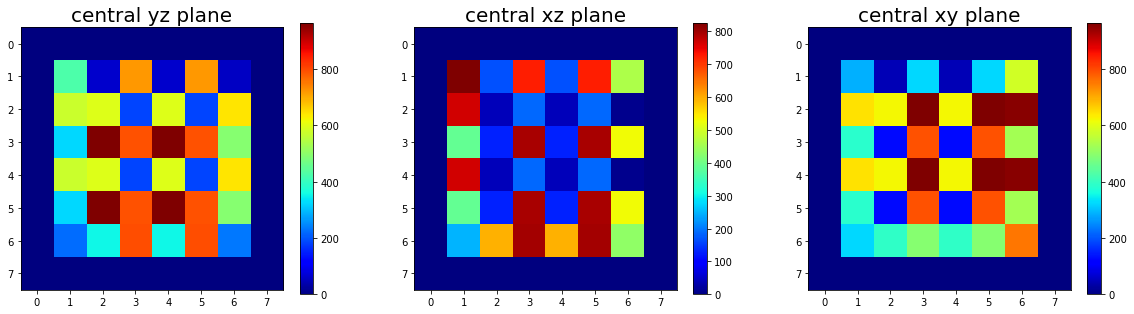

In [ ]:
test_result_1 = np.load("/content/test_output/current_domain_0.npy")
test_result_2 = np.load("/content/test_output/current_domain_1.npy")
test_result_3 = np.load("/content/test_output/current_domain_2.npy")
test_result_4 = np.load("/content/test_output/current_domain_3.npy")
test_result_5 = np.load("/content/test_output/current_domain_4.npy")
test_result_6 = np.load("/content/test_output/current_domain_5.npy")
test_result_7 = np.load("/content/test_output/current_domain_6.npy")
test_result_8 = np.load("/content/test_output/current_domain_7.npy")

temp1 = np.concatenate([test_result_1,test_result_2], axis = 2)
temp2 = np.concatenate([test_result_3,test_result_4], axis = 2)
level_1 = np.concatenate([temp1, temp2], axis = 1)

temp3 = np.concatenate([test_result_5,test_result_6], axis = 2)
temp4 = np.concatenate([test_result_7,test_result_8], axis = 2)
level_2 = np.concatenate([temp3, temp4], axis = 1)

merged_domain = np.concatenate([level_1,level_2], axis=0)
print(test_result_1.shape)
print(merged_domain.shape)
# plot_cube(merged_domain.reshape(1,8,8,8,1),2)

fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(merged_domain[:,:,3], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(merged_domain[:,3,:], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(merged_domain[3,:,:], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)
print(test_result_1)

In [ ]:
# ! python -m pip install --upgrade pip
# ! python -m pip install yt
# yt is a lib for plotting cfd patterns, could be useful in the future 

In [ ]:
%%writefile contiguous.py
import numpy as np
import random # random.randint(1,N), random.random()
import sys
from mpi4py import MPI

comm = MPI.COMM_WORLD
procid = comm.Get_rank()
nprocs = comm.Get_size()
if nprocs<2:
  print("C'mon, get real....")
  sys.exit(1)

sender = 0; receiver = 1; the_other = 1-procid
count = 5

source = np.empty(count,dtype=np.float64)
target = np.empty(count,dtype=np.float64)

for i in range(count):
  source[i] = i+.5

if procid==sender: 
  newcontiguoustype = MPI.DOUBLE.Create_contiguous(count)
  newcontiguoustype.Commit()
  comm.Send([source,1,newcontiguoustype],dest=the_other)
  newcontiguoustype.Free()
elif procid==receiver:
  comm.Recv([target,count,MPI.DOUBLE],source=the_other)
  print(target)

if procid==sender:
  print("finished")

if procid==receiver:
  for i in range(count):
    if target[i]!=source[i]:
      print("error in location %d: %e s/b %e" % (i,target[i],source[i]))

Overwriting contiguous.py


In [ ]:
! mpiexec --allow-run-as-root -n 2 python contiguous.py # less overhead if declared as continuous type?

finished
[0.5 1.5 2.5 3.5 4.5]


In [ ]:
%%writefile indexed.py
import numpy as np
import random # random.randint(1,N), random.random()
from mpi4py import MPI

comm = MPI.COMM_WORLD
procid = comm.Get_rank()
nprocs = comm.Get_size()
if nprocs<2:
  print("C'mon, get real....")
  sys.exit(1)

sender = 0; receiver = 1; the_other = 1-procid
count = 5; totalcount = 15
displacements = np.empty(count,dtype=int)
blocklengths = np.empty(count,dtype=int)
source = np.empty(totalcount,dtype=np.float64)
target = np.empty(count,dtype=np.float64)
idcs = [2,3,5,7,11]

for i in range(len(idcs)):
  displacements[i] = idcs[i]
  blocklengths[i] = 1

for i in range(totalcount):
  source[i] = i+.5

if procid==sender:
  newindextype = MPI.DOUBLE.Create_indexed(blocklengths,displacements)
  newindextype.Commit()
  comm.Send([source,1,newindextype],dest=the_other)
  newindextype.Free()

elif procid==receiver:
  comm.Recv([target,count,MPI.DOUBLE],source=the_other)

if procid==sender:
  print("finished")

if procid==receiver:
  target_loc = 0
  for block in range(count):
    for element in range(blocklengths[block]):
      source_loc = displacements[block]+element
      if target[target_loc]!=source[source_loc]:
        print("error in src/tar location %d/%d: %e s/b %e" \
        % (source_loc,target_loc,target[target_loc],source[source_loc]) )
      target_loc += 1

Overwriting indexed.py


In [ ]:
! mpiexec --allow-run-as-root -n 2 python indexed.py

finished


## Python One-sided communication (?)

In [ ]:
%%writefile putfence.py 
import numpy as np
import random # random.randint(1,N), random.random()
import sys
from mpi4py import MPI

comm = MPI.COMM_WORLD
procid = comm.Get_rank()
nprocs = comm.Get_size()

if nprocs<2:
  print("C'mon, get real....")
  sys.exit(1)

intsize = np.dtype('int').itemsize
print("INT_SIZE: ", intsize)
window_data = np.zeros(2,dtype=int)
win = MPI.Win.Create(window_data,intsize,comm=comm) # create window with size 2
my_number = np.empty(1,dtype=int) # updating data buffer
src = 0
tgt = nprocs-1

if procid==src:
  my_number[0] = 37
else:
  my_number[0] = 1

# between the 2 window fence is a epoch
win.Fence()

if procid==src:
# put data in the second element of the window
  win.Put(my_number,tgt,target=0) # put(buffer, recv, Optional, Target means target index of the window)

win.Fence()

if procid==src:
  print("Window of {} after put:".format(procid),window_data)

if procid==tgt:
  print("Window of {} after put:".format(procid),window_data)

Overwriting putfence.py


In [ ]:
! mpiexec --allow-run-as-root -n 2 python putfence.py

INT_SIZE:  8
INT_SIZE:  8
Window of 0 after put: [0 0]
Window of 1 after put: [37  0]


In [ ]:
%%writefile getfence.py

import numpy as np
import random
from mpi4py import MPI

comm = MPI.COMM_WORLD
procid = comm.Get_rank()
nprocs = comm.Get_size()

if nprocs<2:
  print("C'mon, get real....")
  sys.exit(1)

other = nprocs-1-procid
mydata = random.random()

# if procid==0 or procid==nprocs-1:
win_mem = np.empty(2,dtype=np.float64 )
win = MPI.Win.Create( win_mem,comm=comm ) # create a window with 1 numpy float64
  # Create(memory, disp_unit=1, info=INFO_NULL, comm=COMM_SELF)
# else:
#   win = MPI.Win.Create( None,comm=comm ) # a window with None type?

# put data on another process
win.Fence()

# if procid==0 or procid==nprocs-1:
putdata = np.empty( 2,dtype=np.float64 )
putdata[0] = mydata
putdata[1] = mydata
print(type(putdata))
print("[%d] putting to %d" % (procid,other), putdata)
win.Put(putdata,other)

win.Fence()

# see what you got
# if procid==0 or procid==nprocs-1:
print("[%d] getting" % (procid),win_mem)

win.Free() # free the window

Overwriting getfence.py


In [ ]:
! mpiexec --allow-run-as-root -n 4 python getfence.py

<class 'numpy.ndarray'>
[0] putting to 3 [0.64109989 0.64109989]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[3] putting to 0 [0.15661534 0.15661534]
[2] putting to 1 [0.7730056 0.7730056]
[1] putting to 2 [0.43672608 0.43672608]
[3] getting [0.64109989 0.64109989]
[1] getting [0.7730056 0.7730056]
[2] getting [0.43672608 0.43672608]
[0] getting [0.15661534 0.15661534]


In [ ]:
%%writefile passive.py
import numpy as np
import random # random.randint(1,N), random.random()
from mpi4py import MPI

comm = MPI.COMM_WORLD
procid = comm.Get_rank()
nprocs = comm.Get_size()

if nprocs<2:
  print("C'mon, get real....")
  sys.exit(1)

repository = 0 # process that keeps the repository
ninputs = nprocs-1
checksum = nprocs*(nprocs-1)/2.

if procid==repository:
# repository process creates a table of inputs
# and associates it with the window
  print("[WINDOW_SIZE OF REPOSIOTRY]", ninputs)
  win_mem = np.empty(ninputs,dtype=np.float32)
  win = MPI.Win.Create(win_mem,comm=comm)
else:
# everyone else has an empty window
  win = MPI.Win.Create(None,comm=comm)

# myjobs = np.zeros(ninputs,dtype=int)

if procid!=repository:
  contribution = np.empty(1,dtype=np.float32)
  contribution[0] = 1.*procid
  table_element = np.empty(1,dtype=np.float32)

  win.Lock(repository,lock_type=MPI.LOCK_EXCLUSIVE)
  print("[CONTRIBUTION]",contribution,"[TABLE ELEMENT]",table_element)
  win.Fetch_and_op(contribution,table_element,repository,0,MPI.SUM)
  # Fetch_and_op(origin, result, target_rank, target_disp=0, op=SUM)
  win.Unlock(repository)
  print(procid,"added its contribution to partial sum",table_element[0])

win.Free()

if procid==repository:
  if abs(win_mem[0]-checksum)>1.e-12:
    print("Incorrect result %e s/b %e" % (win_mem[0],checksum))
  print("finished")

Overwriting passive.py


In [ ]:
! mpiexec --allow-run-as-root -n 2 python passive.py

[WINDOW_SIZE OF REPOSIOTRY] 1
[CONTRIBUTION] [1.] [TABLE ELEMENT] [1.e-06]
1 added its contribution to partial sum 2.0
Incorrect result 3.000000e+00 s/b 1.000000e+00
finished


In [ ]:
%%writefile mpi_2d_test_one_sided.py

## PUT strategy
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt

def domain_decomposition_grid(mesh, rows, cols):
    nx, ny = mesh.shape
    assert nx % rows == 0, f"{nx} rows is not evenly divisible by {rows}"
    assert ny % cols == 0, f"{ny} cols is not evenly divisible by {cols}"
    sub_nx = nx//rows
    sub_ny = ny//cols
    return (mesh.reshape(nx//sub_nx, sub_nx, -1, sub_ny)
            .swapaxes(1, 2)
            .reshape(-1, sub_nx, sub_ny))
    

# ==============================================================================
mesh = np.array([[266, 827, 942, 738, 202, 794,  19, 552],
 [228, 168, 668, 861, 474, 826, 108, 298],
 [331, 966, 524, 114, 430, 265, 484,  61],
 [ 18, 505, 764, 457, 870, 835, 701,  44],
 [717, 855, 487, 876, 467, 464,  88, 700],
 [686, 323, 951, 805, 948, 191, 870, 279],
 [955, 829, 200, 708, 256, 425, 596, 640],
 [996, 103, 511, 385, 396, 924, 582, 502]]) 

num_process = MPI.COMM_WORLD.Get_size() # get number of process
assert num_process > 1, f"Parallelisation involves 2 or more processes, otherwise run implementation without MPI"

comm = MPI.COMM_WORLD.Create_cart(
    (2,2),
    periods=(False,False), # set True if periodic boundary
    reorder=True,
    )
  
# comm.rank
rank = comm.rank
print("[RANK] ",comm.rank)

LEFT = 0
RIGHT = 1
TOP = 2
BOTTOM = 3

# if the process arrays is 2D then use grid decomposition to split domain
sub_domains = domain_decomposition_grid(mesh.reshape(8,8), 2, 2)
sub_nx, sub_ny = sub_domains[0].shape

# create customized MPI datatype ...
grid_size = [sub_nx,sub_ny]
subdomain_size = [sub_nx+2, sub_ny + 2]
start_indices = [1,1]

neighbors = [0, 0, 0, 0, 0, 0] # processor rank of all neighbors

# find the processor id of all neighboring processors
neighbors[TOP], neighbors[BOTTOM] = comm.Shift(0, 1)
neighbors[LEFT], neighbors[RIGHT]  = comm.Shift(1, 1)

current_domain = np.pad(sub_domains[rank],(1,1),"constant",constant_values=(0,))

print("neighbors of {}".format(rank),neighbors)

print("CURRENT_DOMAIN_{}".format(rank),current_domain)

# create window with halo cells
window_memory = np.empty(6,dtype=np.float64)
window = MPI.Win.Create(window_memory,comm=comm)

bound_indices = [1,-2,1,-2]
halo_indices = [0,-1,0,-1]

for k,i in enumerate(neighbors[0:4]):
  if k < 2:
    local_region = current_domain[:,bound_indices[k]].ravel()
  else:
    local_region = current_domain[bound_indices[k],:].ravel()

  send_buffer = np.empty(6,np.float64)
  send_buffer[:] = local_region[:]
  #print("SEND_BUFFER to {}".format(i), send_buffer)

  # skip null neighbors
  if i == -2:
    continue
  
  # epoch
  window.Fence() ## START

  window.Put(send_buffer,i)

  window.Fence() ## END

  #print("window data of {} after put: ".format(rank), window_memory)

  # halo update
  if k < 2:
    # print("recv {}".format(rank),window_memory)
    current_domain[:,halo_indices[k]] = window_memory
  else:
    current_domain[halo_indices[k],:] = window_memory

# print("window data of {} after put: ".format(rank), window_memory)

window.Free()

print("CURRENT_DOMAIN_{}".format(rank),current_domain)

Overwriting mpi_2d_test_one_sided.py


In [ ]:
! mpiexec --allow-run-as-root -n 4 python mpi_2d_test_one_sided.py

[RANK]  0
neighbors of 0 [-2, 1, -2, 2, 0, 0]
[RANK]  1
[RANK]  2
CURRENT_DOMAIN_0 [[  0   0   0   0   0   0]
 [  0 266 827 942 738   0]
 [  0 228 168 668 861   0]
 [  0 331 966 524 114   0]
 [  0  18 505 764 457   0]
 [  0   0   0   0   0   0]]
neighbors of 1 [0, -2, -2, 3, 0, 0]
neighbors of 2 [-2, 3, 0, -2, 0, 0]
CURRENT_DOMAIN_1 [[  0   0   0   0   0   0]
 [  0 202 794  19 552   0]
 [  0 474 826 108 298   0]
 [  0 430 265 484  61   0]
 [  0 870 835 701  44   0]
 [  0   0   0   0   0   0]][RANK]  3
CURRENT_DOMAIN_2 [[  0   0   0   0   0   0]
 [  0 717 855 487 876   0]
 [  0 686 323 951 805   0]
 [  0 955 829 200 708   0]
 [  0 996 103 511 385   0]
 [  0   0   0   0   0   0]]
neighbors of 3 [2, -2, 1, -2, 0, 0]

CURRENT_DOMAIN_3 [[  0   0   0   0   0   0]
 [  0 467 464  88 700   0]
 [  0 948 191 870 279   0]
 [  0 256 425 596 640   0]
 [  0 396 924 582 502   0]
 [  0   0   0   0   0   0]]
CURRENT_DOMAIN_3 [[457 870 835 701  44   0]
 [876 467 464  88 700   0]
 [805 948 191 870 279   0